In [49]:
import numpy as np
import os
from time import time
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda,Input,Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Activation, Add, Multiply
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Build Data Loader

In [ ]:
class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation

        self.X_path, self.Y_dict = self.search_data() 

        self.print_stats()
        return None
        
    def search_data(self):
        X_path = []
        Y_dict = {}
        
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
  
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
 
        batch_path = [self.X_path[k] for k in batch_indexs]
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        num_pad = target_frames - len(sampled_video)
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try: 
                    padding.append(video[i])
                except:
                    padding.append(video[0])
            sampled_video += padding     
        return np.array(sampled_video, dtype=np.float32)
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        data = np.load(path, mmap_mode='r')
        data = np.float32(data)

        data = self.uniform_sampling(video=data, target_frames=64)
      
        if  self.data_aug:
            data[...,:3] = self.color_jitter(data[...,:3])
            data = self.random_flip(data, prob=0.5)

        data[...,:3] = self.normalize(data[...,:3])
        data[...,3:] = self.normalize(data[...,3:])
        return data
    

### Build Model

In [ ]:
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt

In [ ]:
inputs = Input(shape=(64,224,224,5))

rgb = Lambda(get_rgb,output_shape=None)(inputs)
opt = Lambda(get_opt,output_shape=None)(inputs)

##################################################### RGB channel
rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
            16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
            16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
            32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
            32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

##################################################### Optical Flow channel
opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
            32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = Conv3D(
            32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)


##################################################### Fusion and Pooling
x = Multiply()([rgb,opt])
x = MaxPooling3D(pool_size=(8,1,1))(x)

##################################################### Merging Block
x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,3,3))(x)

##################################################### FC Layers
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Build the model
pred = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 5)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 64, 224,   │          0 │ input_layer_5[0]… │
│                     │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 64, 224,   │          0 │ input_layer_5[0]… │
│                     │ 224, 2)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_66 (Conv3D)  │ (None, 64, 224,   │        448 │ lambda_6[0][0]    │
│                     │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_74 (Conv3D)  │ (None, 64, 224,   │        304 │ lambda_7[0][0]    │
│                     │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_67 (Conv3D)  │ (None, 64, 224,   │        784 │ conv3d_66[0][0]   │
│                     │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_75 (Conv3D)  │ (None, 64, 224,   │        784 │ conv3d_74[0][0]   │
│                     │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_36    │ (None, 64, 112,   │          0 │ conv3d_67[0][0]   │
│ (MaxPooling3D)      │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_40    │ (None, 64, 112,   │          0 │ conv3d_75[0][0]   │
│ (MaxPooling3D)      │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_68 (Conv3D)  │ (None, 64, 112,   │      2,320 │ max_pooling3d_36… │
│                     │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_76 (Conv3D)  │ (None, 64, 112,   │      2,320 │ max_pooling3d_40… │
│                     │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_69 (Conv3D)  │ (None, 64, 112,   │        784 │ conv3d_68[0][0]   │
│                     │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 64, 112,   │        784 │ conv3d_76[0][0]   │
│                     │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_37    │ (None, 64, 56,    │          0 │ conv3d_69[0][0]   │
│ (MaxPooling3D)      │ 56, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_41    │ (None, 64, 56,    │          0 │ conv3d_77[0][0]   │
│ (MaxPooling3D)      │ 56, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_70 (Conv3D)  │ (None, 64, 56,    │      4,640 │ max_pooling3d_37… │
│                     │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 64, 56,    │      4,640 │ max_pooling3d_41

 Total params: 272,690 (1.04 MB)

 Trainable params: 272,690 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

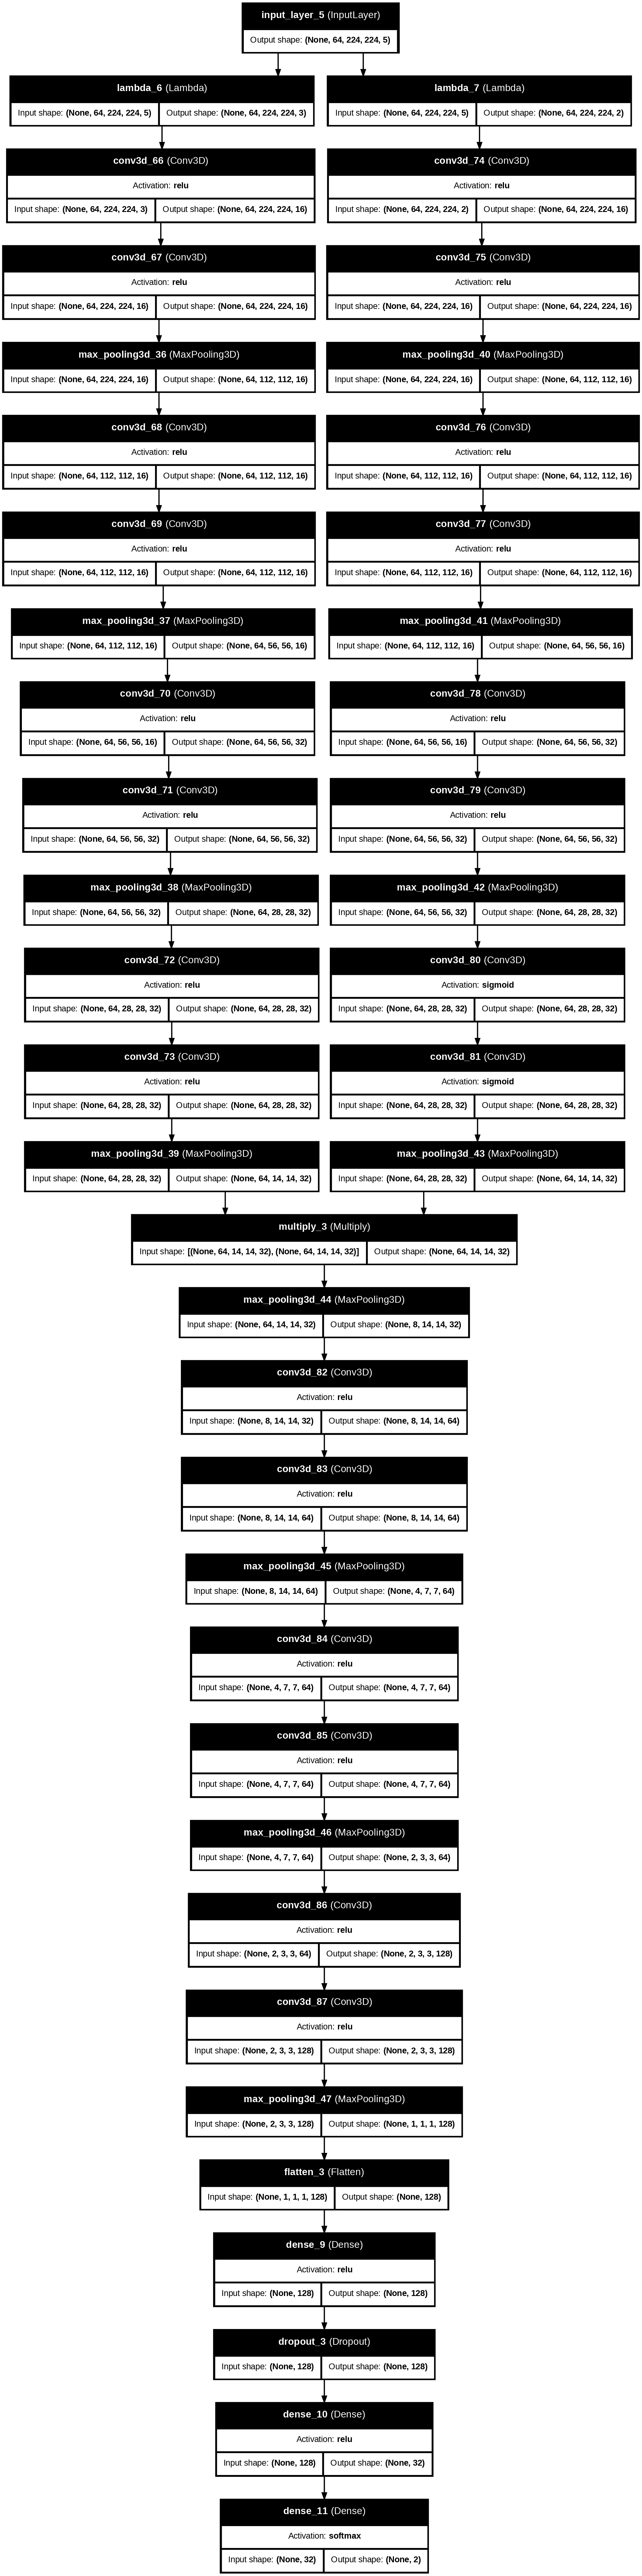

In [ ]:
from keras.utils import plot_model
from IPython.display import Image, display

model_img = plot_model(
    model,
    to_file='/kaggle/working/model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=150,
    show_layer_activations=True
)


display(Image('/kaggle/working/model_architecture.png'))

### Model Compiling

In [55]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### Set Callbacks

- Learning Rate Scheduler

In [56]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.7,
    patience=3,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

- Saving the best model and training logs

In [ ]:
check_point = ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

csv_logger = CSVLogger('/kaggle/working/training_log.csv', separator=',', append=True)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [59]:
callbacks_list = [check_point, csv_logger, early_stop, reduce_lr]

### Model Training

- set essential params

In [60]:
num_epochs  = 30
batch_size  = 8

- init data generator

In [61]:
train_generator = DataGenerator(directory='/kaggle/input/data-rwf/preprocessed_data/train', 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator(directory='/kaggle/input/data-rwf/preprocessed_data/val',
                              batch_size=batch_size, 
                              data_augmentation=False)

Found 1600 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [62]:
hist = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763949881.146284     111 service.cc:148] XLA service 0x7c6bed0085c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763949881.147108     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763949881.796758     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1763949883.328494     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763949883.583757     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763949884.247022     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763949884.5116

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5046 - loss: 0.7138

E0000 00:00:1763951450.759415     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763951451.014709     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763951451.582610     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763951451.847732     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-24 02:30:52.904665: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,16,64,224,224]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,64,224,224]{4,3,2,1,0


Epoch 1: val_accuracy improved from -inf to 0.76250, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1915s 9s/step - accuracy: 0.5047 - loss: 0.7137 - val_accuracy: 0.7625 - val_loss: 0.5550 - learning_rate: 0.0100
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6806 - loss: 0.6015
Epoch 2: val_accuracy improved from 0.76250 to 0.81000, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1980s 10s/step - accuracy: 0.6806 - loss: 0.6015 - val_accuracy: 0.8100 - val_loss: 0.4866 - learning_rate: 0.0100
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7215 - loss: 0.5635
Epoch 3: val_accuracy did not improve from 0.81000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1946s 10s/step - accuracy: 0.7215 - loss: 0.5636 - val_accuracy: 0.8075 - val_loss: 0.5262 - learning_rate: 0.0100
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7663 - loss: 0.5386
Epoch 4: val_accuracy improved from 0.81000 to 0.82250, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1846s 9s/step - accuracy: 0.7663 - loss: 0.5386 - val_accuracy: 0.8225 - val_loss: 0.4375 - learning_rate: 0.0100
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7813 - loss: 0.4907
Epoch 5: val_accuracy improved from 0.82250 to 0.82750, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1762s 9s/step - accuracy: 0.7813 - loss: 0.4907 - val_accuracy: 0.8275 - val_loss: 0.4040 - learning_rate: 0.0100
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7767 - loss: 0.5048
Epoch 6: val_accuracy improved from 0.82750 to 0.83250, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1771s 9s/step - accuracy: 0.7767 - loss: 0.5047 - val_accuracy: 0.8325 - val_loss: 0.4496 - learning_rate: 0.0100
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7786 - loss: 0.4920
Epoch 7: val_accuracy improved from 0.83250 to 0.83500, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1835s 9s/step - accuracy: 0.7787 - loss: 0.4919 - val_accuracy: 0.8350 - val_loss: 0.4005 - learning_rate: 0.0100
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7874 - loss: 0.4461
Epoch 8: val_accuracy improved from 0.83500 to 0.84250, saving model to /kaggle/working/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1773s 9s/step - accuracy: 0.7873 - loss: 0.4462 - val_accuracy: 0.8425 - val_loss: 0.3998 - learning_rate: 0.0100
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8114 - loss: 0.4469
Epoch 9: val_accuracy did not improve from 0.84250
200/200 ━━━━━━━━━━━━━━━━━━━━ 1754s 9s/step - accuracy: 0.8113 - loss: 0.4469 - val_accuracy: 0.7925 - val_loss: 0.4436 - learning_rate: 0.0100
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8064 - loss: 0.4379
Epoch 10: val_accuracy did not improve from 0.84250
200/200 ━━━━━━━━━━━━━━━━━━━━ 1714s 9s/step - accuracy: 0.8064 - loss: 0.4379 - val_accuracy: 0.8400 - val_loss: 0.4289 - learning_rate: 0.0100
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8320 - loss: 0.3995
Epoch 11: val_accuracy did not improve from 0.84250

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1734s 9s/step - accuracy: 0.8320 - loss: 0.3996 - val

200/200 ━━━━━━━━━━━━━━━━━━━━ 1718s 9s/step - accuracy: 0.8495 - loss: 0.3625 - val_accuracy: 0.8650 - val_loss: 0.3750 - learning_rate: 0.0070
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8317 - loss: 0.3650
Epoch 13: val_accuracy did not improve from 0.86500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1739s 9s/step - accuracy: 0.8317 - loss: 0.3650 - val_accuracy: 0.8150 - val_loss: 0.4047 - learning_rate: 0.0070
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8454 - loss: 0.3446
Epoch 14: val_accuracy did not improve from 0.86500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1761s 9s/step - accuracy: 0.8454 - loss: 0.3446 - val_accuracy: 0.7775 - val_loss: 0.5209 - learning_rate: 0.0070
Epoch 15/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8349 - loss: 0.3739
Epoch 15: val_accuracy did not improve from 0.86500

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.004899999825283885.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1729s 9s/step - accuracy: 0.8349 - loss: 0.3738 - v

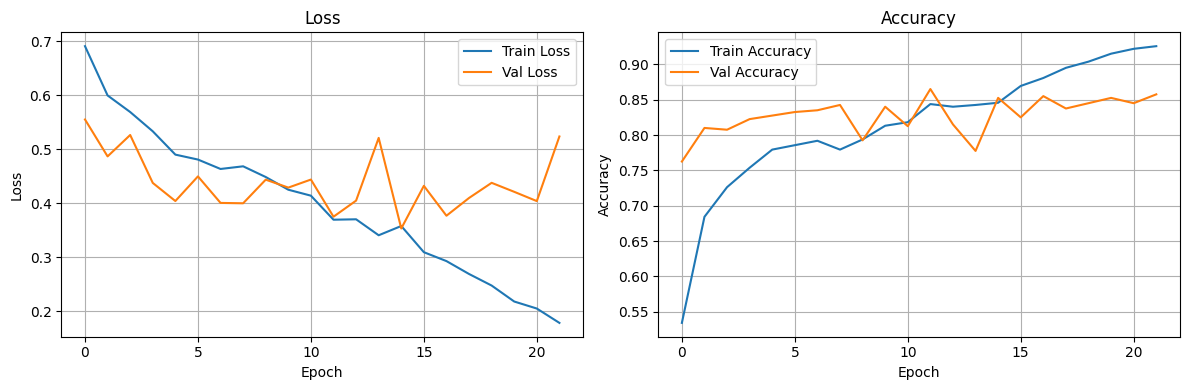

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=300)
plt.show()

In [ ]:
val_generator.shuffle = False 

val_generator.indexes = np.arange(len(val_generator.X_path))

print("Đang dự đoán...")
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = []
for i in range(len(val_generator.X_path)):
    file_path = val_generator.X_path[i]   
    one_hot_label = val_generator.Y_dict[file_path] 
    y_true.append(np.argmax(one_hot_label)) 

y_true = np.array(y_true)

# Cắt ngắn nếu predict bị lệch (phòng hờ)
y_true = y_true[:len(y_pred)]

print("Hoàn tất lấy dữ liệu!")

Đang dự đoán...
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step
Hoàn tất lấy dữ liệu!



CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Fight       0.87      0.86      0.86       200
    NonFight       0.86      0.87      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



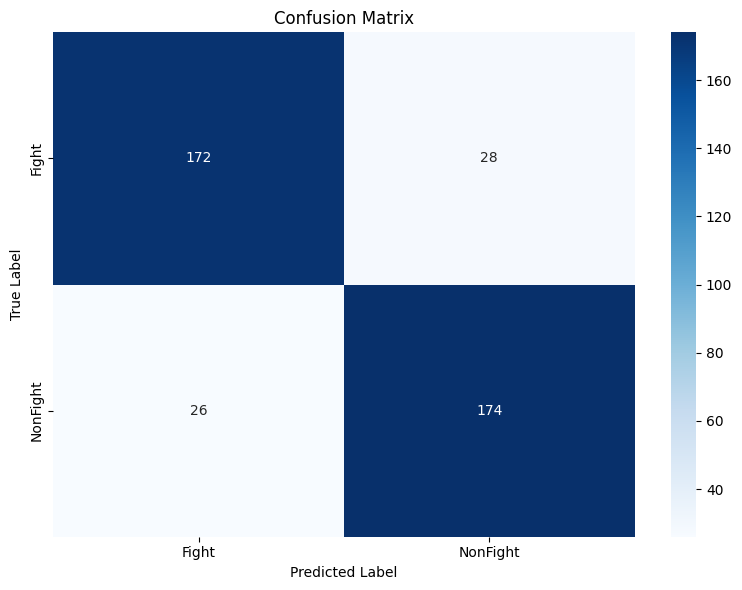

In [ ]:
target_names = val_generator.dirs 

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300)
plt.show()